In [118]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [120]:
len(words)

32033

In [121]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [122]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X is input to NN, Y is labels for each example in X
# for w in words[:5]:
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join([itos[i] for i in context]), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

# convert to torch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

In [123]:
X.shape, X.dtype, Y.shape, Y.dtype 
# dataset of 32 examples, each input to NN in 3 integers. Label is 1 integer

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [124]:
# build embedding look up table
# in paper (A Neural Probabilistic Language Model, Bengio et al. 2003) they use 30 dimensions to store 17000 words
# in our case we only have 27 characters, so let's use 2 dimensions

In [125]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2), generator=g) # each char has 2 dim embedding
C

tensor([[ 1.9269,  1.4873],
        [ 0.9007, -2.1055],
        [ 0.6784, -1.2345],
        [-0.0431, -1.6047],
        [-0.7521,  1.6487],
        [-0.3925, -1.4036],
        [-0.7279, -0.5594],
        [-0.7688,  0.7624],
        [ 1.6423, -0.1596],
        [-0.4974,  0.4396],
        [-0.7581,  1.0783],
        [ 0.8008,  1.6806],
        [ 1.2791,  1.2964],
        [ 0.6105,  1.3347],
        [-0.2316,  0.0418],
        [-0.2516,  0.8599],
        [-1.3847, -0.8712],
        [-0.2234,  1.7174],
        [ 0.3189, -0.4245],
        [-0.8140, -0.7360],
        [-0.8371, -0.9224],
        [ 1.8113,  0.1606],
        [ 0.3672,  0.1754],
        [-1.1845,  1.3835],
        [-1.2024,  0.7078],
        [-1.0759,  0.5357],
        [ 1.1754,  0.5612]])

In [126]:
emb = C[X] # embed the input, shape is (32, 3, 2)
# intuitively, we are looking up the embedding for each character in the input

In [127]:
# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape # concatenate the embeddings for each character in the input
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape # same as above, but more general
# or use emb.view() to reshape the tensor

In [128]:
W1 = torch.randn((6, 100), generator=g) # 6 = 3 * 2, 100 = hidden layer size
b1 = torch.randn((100), generator=g)

In [129]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # h is 100 dim activations
h.shape

torch.Size([228146, 100])

In [130]:
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)

In [131]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

In [132]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [133]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# loss
loss = F.cross_entropy(logits, Y) # same as above, but better to use pytorch implementation for numerical stability and efficiency reasons
loss

tensor(16.7265)

In [134]:
# rewrite more respectfully

for p in parameters:
    p.requires_grad = True

for i in range(10):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    print(f'{i}: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None # reset gradients to zero
    loss.backward()
    
    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

0: 16.726470947265625
1: 14.942935943603516
2: 13.863014221191406
3: 13.00383186340332
4: 12.292206764221191
5: 11.732641220092773
6: 11.270576477050781
7: 10.859724044799805
8: 10.479723930358887
9: 10.136444091796875


In [135]:
# use minibatches
torch.randint(0, X.shape[0], (32,)) # random indices for minibatch

tensor([192381,  19986,  64250,  75763,  47854, 216388, 126820, 168116, 158810,
        198417, 131982, 214689,  48913, 167702,  53043,  39251, 147334, 125048,
        121742, 137193,  62238,  45320, 140631,  88090, 214863, 106391, 109351,
         42641, 133773, 102956, 133832,  31935])

In [136]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10 ** lre
# way of finding a good initial learning rate

In [149]:
# lri = []
# lossi = []

for p in parameters:
    p.requires_grad = True

# for i in range(1000):
for i in range(10000):
    
    # construct minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # 32,3,2 bc minibatch size is 32
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # print(f'{i}: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None # reset gradients to zero
    loss.backward()
    
    # update
    # lr = lrs[i]
    # lr = 0.1 # learning rate decay: use 0.01 after training for a while
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad
        
    # # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

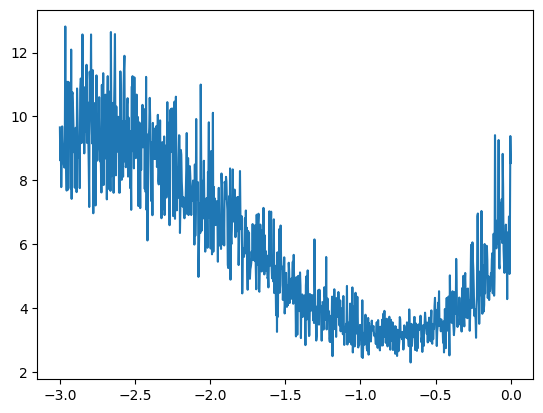

In [138]:
# plt.plot(lri, lossi) 
# # 0.1 is a good learning rate

In [150]:
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss
# acheive loss of 2.3031

tensor(2.3031, grad_fn=<NllLossBackward0>)

In [152]:
# problem: may be overfitting, need to use validation set
# rebuilt dataset with train, val, test splits

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [153]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [159]:
for p in parameters:
    p.requires_grad = True

for i in range(10000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # print(f'{i}: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad

print(loss.item())  


2.42132306098938


In [160]:
# evaluate on dev set
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.4032504558563232

In [ ]:
# acheived very similar loss on dev set, so we are not overfitting
# infact, we are underfitting, so we can expect performance gains by scaling up the model

In [170]:
# try with 300 hidden neurons
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

10281


In [171]:
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(40000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (128,)) # used larger minibatch
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # print(f'{i}: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())  

2.534320831298828


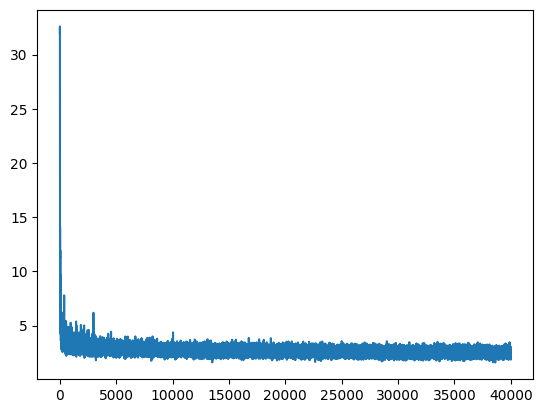

In [169]:
plt.plot(stepi, lossi)

In [172]:
# eval on train set
emb = C[Xtr]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.3494434356689453

In [173]:
# eval on dev set
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3496620655059814

In [ ]:
# similar loss as before, probably limited by size of embeddings

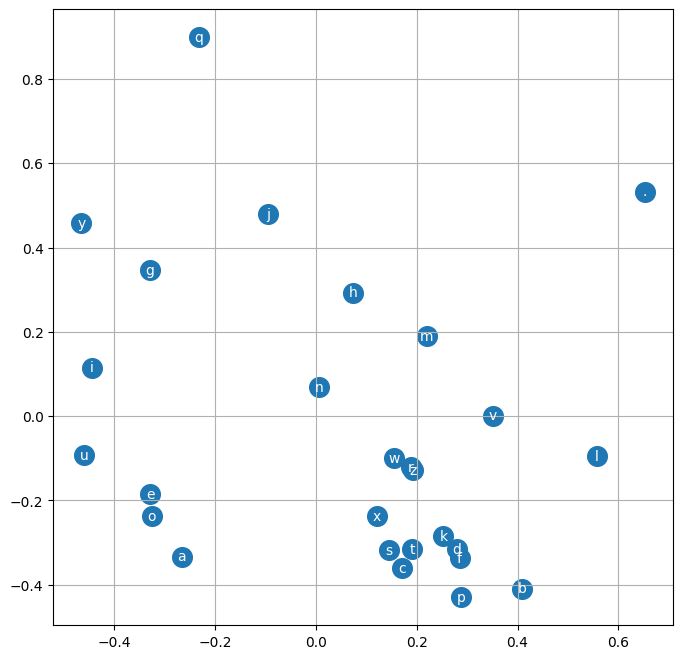

In [174]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# vowels are clustered together
# q, . are far away from other letters

In [181]:
# try with 200 hidden neurons, 10 dimensions for embeddings
g = torch.Generator().manual_seed(42)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

11897


In [192]:
lossi = []
stepi = []

In [193]:
for p in parameters:
    p.requires_grad = True

for i in range(200000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # print(f'{i}: {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    if i < 50000:
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())  

2.1386003494262695


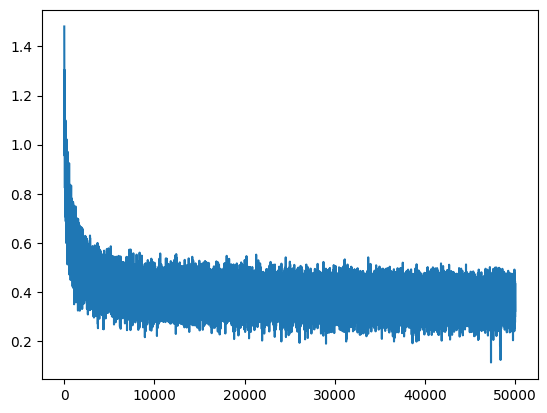

In [184]:
plt.plot(stepi, lossi)

In [194]:
emb = C[Xtr]
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()


2.0762598514556885

In [195]:
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1327333450317383

In [196]:
# now we can evaluate on test set
emb = C[Xte]
h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss.item()
# beat andrei karpathy's loss :) 

2.12931227684021

In [188]:
# sampling from the model:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join([itos[i] for i in out]))

paiyliah.
zumalacyson.
izre.
demiyah.
rowy.
duri.
ezonniyah.
kezlynn.
daiia.
georielley.
kifbarthoniy.
kamarthi.
tymilah.
amiyanna.
makori.
siy.
kiney.
sky.
nyven.
kevill.


In [ ]:
# output looks more like names than before!